In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
ex1 = pd.read_csv("train_주요변수.csv")



★ Validation Accuracy: 0.77686875
              precision    recall  f1-score   support

           0     0.0882    0.9433    0.1612       194
           1     0.1338    0.7241    0.2258        29
           2     0.4295    0.6116    0.5046     25518
           3     0.3809    0.6199    0.4718     69848
           4     0.9574    0.8163    0.8812    384411

    accuracy                         0.7769    480000
   macro avg     0.3979    0.7430    0.4489    480000
weighted avg     0.8450    0.7769    0.8013    480000



C:\Users\AHN\AppData\Local\Temp\ipykernel_2332\2677020290.py:46: UserWarning: Glyph 52397 (\N{HANGUL SYLLABLE CEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AHN\AppData\Local\Temp\ipykernel_2332\2677020290.py:46: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AHN\AppData\Local\Temp\ipykernel_2332\2677020290.py:46: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AHN\AppData\Local\Temp\ipykernel_2332\2677020290.py:46: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AHN\AppData\Local\Temp\ipykernel_2332\2677020290.py:46: UserWarning: Glyph 52852 (\N{HANGUL SYLLABLE KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AHN\AppData\Local\Temp\ipykernel_2332\2677020290.py:46: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu 

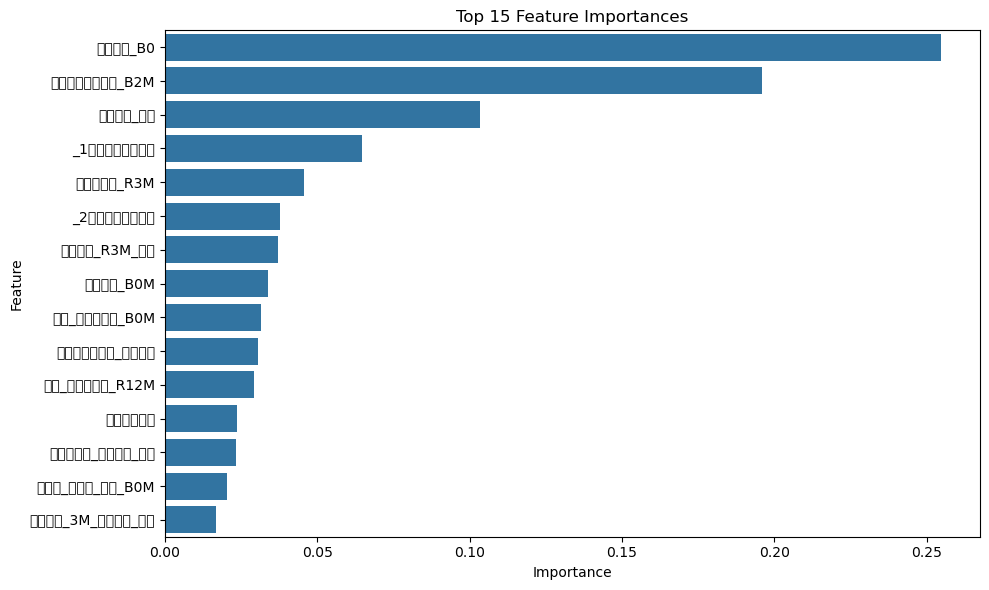

▶ 예측 결과 저장 완료: rf_not_cat.csv
           ID Segment
0  TEST_00000       D
1  TEST_00001       D
2  TEST_00002       D
3  TEST_00003       E
4  TEST_00004       E


In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ─── 1. 데이터 불러오기 ───────────────────────────────
ex1 = pd.read_csv("train_주요변수.csv")
test_df = pd.read_csv("test_주요변수.csv")

# ─── 2. 숫자형 특성 선택 및 라벨 인코딩 ──────────────
X = ex1.drop(columns=['ID', 'Segment']).select_dtypes(include=[np.number])
y, segment_labels = pd.factorize(ex1['Segment'], sort=True)  # A~E → 0~4

# ─── 3. 학습/검증 분할 ────────────────────────────────
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ─── 4. 모델 정의 및 학습 ────────────────────────────
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=10,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# ─── 5. 검증 세트 평가 ────────────────────────────────
y_val_pred = rf.predict(X_val)
print("★ Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=4))

# ─── (선택) 6. 특성 중요도 시각화 ─────────────────────
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# ─── 7. 테스트 데이터 예측 ─────────────────────────────
X_submit = test_df.drop(columns=['ID']).select_dtypes(include=[np.number])
y_submit_pred = rf.predict(X_submit)
predicted_segments = segment_labels[y_submit_pred]

predict = pd.DataFrame({
    'ID': test_df['ID'],
    'Segment': predicted_segments
})

# ─── 8. 결과 저장 ─────────────────────────────────────
predict.to_csv("rf_not_cat.csv", index=False)
print("▶ 예측 결과 저장 완료: rf_not_cat.csv")
print(predict.head())


In [16]:

df_pred = pd.read_csv("rf_not_cat.csv")  # ID, Segment

df_mode = df_pred.groupby("ID")["Segment"].agg(lambda x: x.mode().iloc[0]).reset_index()

# 3. sample_submission 포맷 확인
sample = pd.read_csv("sample_submission.csv")
print("샘플 행 수:", len(sample))  # 100,000

# 4. ID 기준으로 merge
final_submission = sample[['ID']].merge(df_mode, on='ID', how='left')

# 5. Segment가 없는 경우 예비값 지정 (예: 'A')
final_submission['Segment'] = final_submission['Segment'].fillna('C')

# 6. 저장
final_submission.to_csv("final_not_cat_submission.csv", index=False)


샘플 행 수: 100000
